# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from os import listdir
from os.path import isfile, join
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

uncomment following if the data are in the original folder

In [2]:
# load in the data 
#uncomment if the data are in the original folder
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

uncomment following if you want to save as pickle

In [3]:
#save to pickle for faster loading
#uncomment if you

#azdias.to_pickle("./azdias.pkl")
#customers.to_pickle("./customers.pkl")
#mailout_train.to_pickle("./mailout_train.pkl")
#mailout_test.to_pickle("./mailout_test.pkl")

In [6]:
#load in pickle files with data
azdias = pd.read_pickle("../data_arvato_bertelsmann/azdias.pkl")
customers = pd.read_pickle("../data_arvato_bertelsmann/customers.pkl")
mailout_train = pd.read_pickle("../data_arvato_bertelsmann/mailout_train.pkl")
mailout_test = pd.read_pickle("../data_arvato_bertelsmann/mailout_test.pkl")
attributes = pd.read_excel('../data_arvato_bertelsmann//DIAS Attributes - Values 2017.xlsx',header=1, engine='openpyxl')
information = pd.read_excel('../data_arvato_bertelsmann//DIAS Information Levels - Attributes 2017.xlsx',header=1, engine='openpyxl')

In [3]:
attributes.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [4]:
information.shape

(313, 5)

In [5]:
print(azdias.shape)
azdias.head()

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
print(customers.shape)
customers.head()

(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


Error of mixtypes appearing in column 18 and 19 in azdias and customers files wenn getting data.
So we have to check this:

In [8]:
print(customers.iloc[:,18:20].value_counts())
print(azdias.iloc[:,18:20].value_counts())

CAMEO_DEUG_2015  CAMEO_INTL_2015
2                14                 12198
4                24                  8391
6                43                  7158
1                15                  6845
3                25                  5980
                                    ...  
5.0              35.0                 266
7.0              45.0                 258
9.0              52.0                 253
6.0              31.0                 164
X                XX                   126
Length: 67, dtype: int64
CAMEO_DEUG_2015  CAMEO_INTL_2015
9                51                 47054
9.0              51.0               34202
7                41                 34077
6                43                 32730
4                24                 32717
                                    ...  
6.0              35.0                2532
4.0              25.0                2265
7.0              45.0                1931
5.0              35.0                1734
X                XX        

In [9]:
check_types= azdias.applymap(type)
print(check_types[azdias.columns[18]].value_counts())
print(check_types[azdias.columns[19]].value_counts())
print(check_types[azdias.columns[20]].value_counts())

<class 'str'>      459358
<class 'float'>    431863
Name: CAMEO_DEUG_2015, dtype: int64
<class 'str'>      459358
<class 'float'>    431863
Name: CAMEO_INTL_2015, dtype: int64
<class 'float'>    891221
Name: CJT_GESAMTTYP, dtype: int64


In [10]:
check_types= customers.applymap(type)
print(check_types[customers.columns[18]].value_counts())
print(check_types[customers.columns[19]].value_counts())
print(check_types[customers.columns[20]].value_counts())

<class 'str'>      105198
<class 'float'>     86454
Name: CAMEO_DEUG_2015, dtype: int64
<class 'str'>      105198
<class 'float'>     86454
Name: CAMEO_INTL_2015, dtype: int64
<class 'float'>    191652
Name: CJT_GESAMTTYP, dtype: int64


Both of the columns contains the types: string, int and float. We will convert the strings to NAN, the float to int

In [11]:
check_types= azdias.applymap(type)
print(check_types[azdias.columns[18]].value_counts())
print(check_types[azdias.columns[19]].value_counts())
check_types= customers.applymap(type)
print(check_types[customers.columns[18]].value_counts())
print(check_types[customers.columns[19]].value_counts())

<class 'str'>      459358
<class 'float'>    431863
Name: CAMEO_DEUG_2015, dtype: int64
<class 'str'>      459358
<class 'float'>    431863
Name: CAMEO_INTL_2015, dtype: int64
<class 'str'>      105198
<class 'float'>     86454
Name: CAMEO_DEUG_2015, dtype: int64
<class 'str'>      105198
<class 'float'>     86454
Name: CAMEO_INTL_2015, dtype: int64


Missing values of azdias

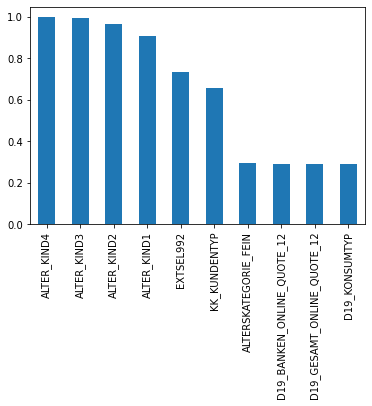

In [12]:
azdias.isnull().mean().nlargest(10).plot.bar()

Missing values of customers

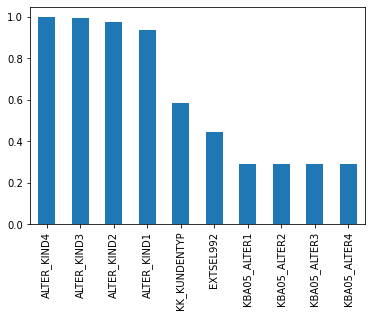

In [13]:
customers.isnull().mean().nlargest(10).plot.bar()

Histogram of missing values azdias

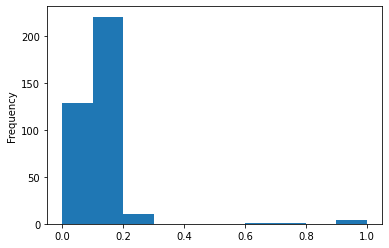

In [14]:
azdias.isnull().mean().plot.hist()

Histogram of missing values customers

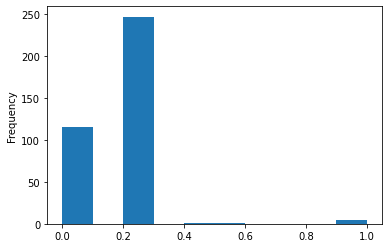

In [15]:
customers.isnull().mean().plot.hist()

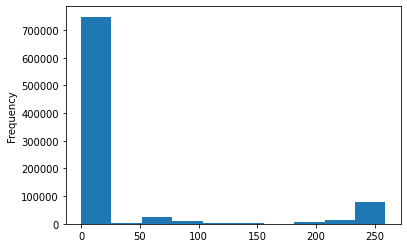

In [16]:
azdias.isnull().sum(axis=1).plot.hist()

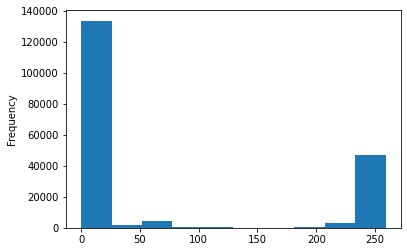

In [17]:
customers.isnull().sum(axis=1).plot.hist()

In [18]:
#drop additional three columns which are missing in azdias to harmonize
customers_copy = customers.copy()
customers_clean = customers_copy.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=False, axis=1)

In [19]:
#dropping columns that have more than 40 % nan (coustomers and azdias is combined)
drop_col = customers.columns[customers.isnull().mean()>0.4]|azdias.columns[azdias.isnull().mean()>0.4]
azdias_clean = azdias.drop(drop_col, axis=1)
customers_clean = customers_clean.drop(drop_col, axis=1)

In [20]:
#drop rows with more than 25 missing 
azdias_clean = azdias_clean.dropna(thresh=azdias_clean.shape[1]-25)
customers_clean = customers_clean.dropna(thresh=customers_clean.shape[1]-25)

In [21]:
attributes = pd.read_excel('../data_arvato_bertelsmann//DIAS Attributes - Values 2017.xlsx',header=1, engine='openpyxl')
attributes['Attribute'] = attributes['Attribute'].ffill()
attributes['Description'] = attributes['Description'].ffill()
attributes = attributes.drop(['Unnamed: 0'], axis=1)
unique_atrributes = set(attributes.Attribute.tolist())

In [22]:
len(set(customers_clean.columns) & set(azdias_clean.columns))
#len(unique_to_azdias)
sorted(unique_atrributes)

['AGER_TYP',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'BIP_FLAG',
 'CAMEO_DEUG_2015',
 'CAMEO_DEUINTL_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KONSUMTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITT

In [23]:
list(set(azdias_clean.columns.tolist()) - set(unique_atrributes))
#sorted(azdias_clean.columns.tolist())

['VHA',
 'D19_TELKO_MOBILE',
 'D19_BIO_OEKO',
 'STRUKTURTYP',
 'VK_ZG11',
 'KBA13_KMH_210',
 'RT_UEBERGROESSE',
 'CJT_TYP_5',
 'KONSUMZELLE',
 'RT_SCHNAEPPCHEN',
 'KBA13_GBZ',
 'ARBEIT',
 'CJT_TYP_4',
 'D19_SOZIALES',
 'D19_HANDWERK',
 'DSL_FLAG',
 'D19_VERSICHERUNGEN',
 'SOHO_KZ',
 'KBA13_ANTG2',
 'D19_BANKEN_DIREKT',
 'D19_VERSI_DATUM',
 'LNR',
 'FIRMENDICHTE',
 'D19_BANKEN_LOKAL',
 'KBA13_ANTG3',
 'D19_WEIN_FEINKOST',
 'CJT_TYP_1',
 'D19_TECHNIK',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_VERSI_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_SCHUHE',
 'D19_FREIZEIT',
 'D19_DROGERIEARTIKEL',
 'D19_HAUS_DEKO',
 'D19_RATGEBER',
 'D19_LEBENSMITTEL',
 'KBA13_BAUMAX',
 'UMFELD_ALT',
 'RT_KEIN_ANREIZ',
 'D19_VERSAND_REST',
 'D19_BILDUNG',
 'D19_BUCH_CD',
 'UMFELD_JUNG',
 'D19_ENERGIE',
 'VHN',
 'D19_VERSI_ONLINE_DATUM',
 'D19_BEKLEIDUNG_REST',
 'D19_BANKEN_REST',
 'AKT_DAT_KL',
 'D19_SAMMELARTIKEL',
 'HH_DELTA_FLAG',
 'KBA13_ANTG1',
 'MOBI_RASTER',
 'AN

In [8]:
azdias.isnull().sum(axis=1)

0         252
1          15
2           5
3           7
4           5
         ... 
891216     11
891217      6
891218      8
891219      4
891220     16
Length: 891221, dtype: int64

Here we create function to clean the data that we can reuse for all the following tasks

In [2]:
def clean_data(df, drop_rows=True):
    # create copy of df
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    #df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)

    # This part converts types of columns 18 and 19 of azias and coustomers df 
    # from float to int and from string to NAN
    col_names = df.iloc[:,18:20].columns
    df[col_names] = df[col_names].replace({'X': -1, 'XX': -1})    
    #df_copy[col_names[0]] = pd.to_numeric(df_copy[col_names[0]], downcast="float")
    #df_copy[col_names[1]] = pd.to_numeric(df_copy[col_names[1]], downcast="float")
    df[col_names] = df[col_names].fillna(-1)
    df[col_names] = df[col_names].astype(int)
    df[['OST_WEST_KZ', 'CAMEO_DEU_2015']] = df[['OST_WEST_KZ', 'CAMEO_DEU_2015']].fillna(-1)
    #df_copy[['OST_WEST_KZ', 'CAMEO_DEU_2015']] df df_copy[['OST_WEST_KZ', 'CAMEO_DEU_2015']].astype(int)
    df[['OST_WEST_KZ', 'CAMEO_DEU_2015']] = df[['OST_WEST_KZ', 'CAMEO_DEU_2015']].fillna(-1)

    print("df columns 18 and 19 converted to float")
    print("shape is: ", df.shape)
    # drop all columns with more than 40 percent missing values
    drop_col = df.columns[df.isnull().mean()>0.4]
    df = df.drop(drop_col, axis=1)
    print("df columns with more than 40 percent missing values dropped")
    print("dropped columns are: ", drop_col)
    print("shape is: ", df.shape)
    #drop rows with more than 25 missing 
    if(drop_rows):
        df = df.dropna(thresh=df.shape[1]-25)
    print("df rows with 25 missing values dropped")
    print("shape is: ", df.shape)
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find features with correlation greater than 0.8
    to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
    # drop columns with high correlation 
    df = df.drop(to_drop, axis=1)
    print("columns with correlation more than 0.7 are dropped")
    
    # this is just for the costumer df 
    list_cost_col = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
    for col in list_cost_col:
        if col in df.columns:
            df = df.drop([col], inplace=False, axis=1)
        print("this columns from customer df are dropped: ", ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])
        print("shape is: ", df.shape)
    
    #fill object with dummies
    df = pd.get_dummies(df)

    columns_df = list(df.columns.values)

    #imputing the nan value with mode
    print('Imputing nan values with mode')
    mode_imputer = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
    #mode_imputer = mode_imputer.fit(data_df)
    df = mode_imputer.fit_transform(df)
    df = pd.DataFrame(df)
    print('shape after imputing the values', df.shape)

    #converting all values in df to int
    df = df.astype(int)
    
    # normalize df
    normalize = StandardScaler(copy=False).fit_transform(df)
    df = pd.DataFrame(normalize,columns= columns_df)
    print('Shape after normalising' , df.shape)
        
    df = df.set_index('LNR')

    return df

In [8]:
azdias_clean = clean_data(azdias)

df columns 18 and 19 converted to float
shape is:  (891221, 364)
df columns with more than 40 percent missing values dropped
dropped columns are:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')
shape is:  (891221, 358)
df rows with 25 missing values dropped
shape is:  (750582, 358)
columns with correlation more than 0.7 are dropped
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (750582, 236)
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (750582, 236)
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (750582, 236)
Imputing nan values with mode
shape after imputing the values (750582, 282)
Shape after normalising (750582, 282)


In [3]:
#azdias_clean.to_pickle("./azdias_clean.pkl")
azdias_clean = pd.read_pickle("./azdias_clean.pkl")

In [7]:
customers_clean = clean_data(customers)
#customers_clean = customers_clean.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=False, axis=1)


df columns 18 and 19 converted to float
shape is:  (191652, 367)
df columns with more than 40 percent missing values dropped
dropped columns are:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')
shape is:  (191652, 361)
df rows with 25 missing values dropped
shape is:  (135043, 361)
columns with correlation more than 0.7 are dropped
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (135043, 265)
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (135043, 264)
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (135043, 263)
Imputing nan values with mode
shape after imputing the values (135043, 309)
Shape after normalising (135043, 309)


In [ ]:
#customers_clean.to_pickle("./customers_clean.pkl")
customers_clean = pd.read_pickle("./customers_clean.pkl")

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

With pca we are able to reduce the dimension of data and with the explained variance we are able to reduce compents but to keep the informations with high variance.

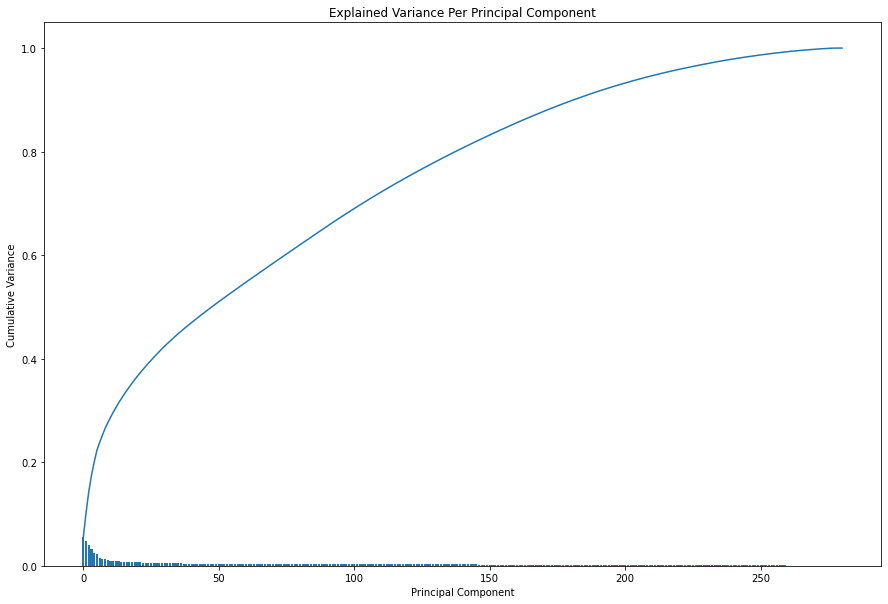

In [4]:
#graph for pca
plt.figure(figsize=(15,10))
pca_df = PCA().fit(azdias_clean)
plt.plot(np.cumsum(pca_df.explained_variance_ratio_))
plt.bar(range(0,len(pca_df.explained_variance_ratio_)), pca_df.explained_variance_ratio_)

plt.xlabel('Principal Component')
plt.title("Explained Variance Per Principal Component")
plt.ylabel('Cumulative Variance')
plt.show()

Here we see a flattern curve at 200 components, So we will keep them with a high variance.

In [8]:
#reduce data on dataset azdias
pca = PCA(n_components=200)
azdias_pca = pca.fit_transform(azdias_clean)

In [11]:
#reduce data on dataset customers
customers_pca = pca.fit_transform(customers_clean)

We want to the sum of the squared differences for different number of clusters to chose a number of clusters

In [7]:
#Clustering
cluster_number = []
score_k_mean =[]
for cluster_nr in range(1,20,1):
    k_mean = KMeans(cluster_nr)
    model_k_mean = k_mean.fit(azdias_pca)
    score_k_mean.append(np.abs(model_k_mean.score(azdias_pca)))
    cluster_number.append(cluster_nr)

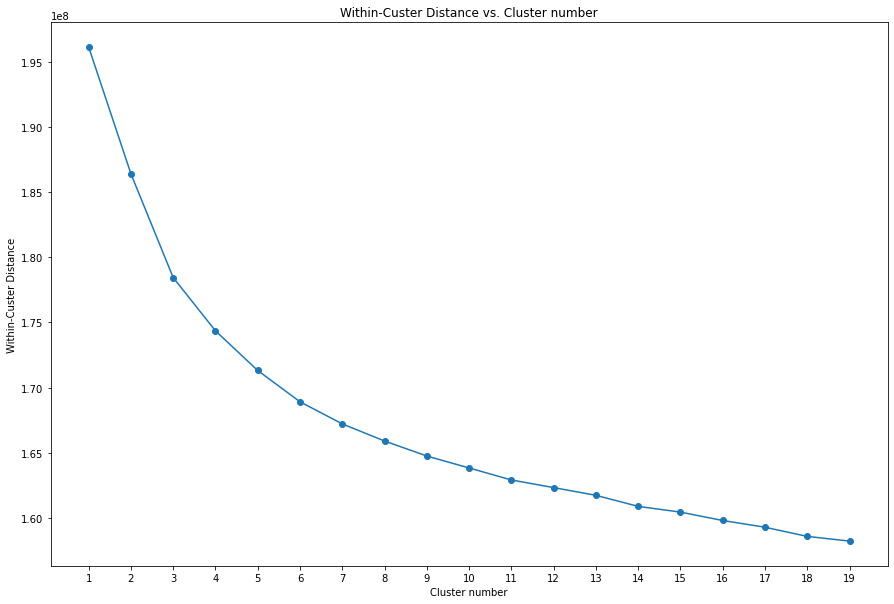

In [8]:
plt.figure(figsize=(15,10))
plt.plot(cluster_number, score_k_mean, linestyle='-', marker='o')
plt.xticks(list(range(1,20,1)))
plt.xlabel('Cluster number')
plt.ylabel('Within-Custer Distance')
plt.title('Within-Custer Distance vs. Cluster number');



Because at cluster number 11 the curve flatterns, we will build 11 clusters

In [9]:
#create model with 11 clusters
kmeans = KMeans(n_clusters = 11)
kmeans_model = kmeans.fit(azdias_pca)
azdias_prediction = kmeans_model.predict(azdias_pca)

In [12]:
customers_prediction = kmeans_model.predict(customers_pca)

In [23]:
#compare clusters
df_cluster_customer = pd.Series(customers_prediction)
df_cluster_gp = pd.Series(azdias_prediction)

In [38]:
#get values of each cluster and sort the df for comparing
value_cluster_customer = df_cluster_customer.value_counts().sort_index()
value_cluster_customer.rename ='values of customers'
value_cluster_gp = df_cluster_gp.value_counts().sort_index()
value_cluster_gp.rename ='values of gp'

In [43]:
# Compare the cluster distribution between general population and customers
df_gp_customers_value = pd.concat([value_cluster_customer, value_cluster_gp], axis=1)
df_gp_customers_value.columns = ['values of customers', 'values of gp']
df_gp_customers_value.index.names = ['Cluster Number']
df_gp_customers_value['difference'] = (df_gp_customers_value['values of customers']/df_gp_customers_value['values of customers'].sum()*100)- (df_gp_customers_value['values of gp']/df_gp_customers_value['values of gp'].sum()*100)
df_gp_customers_value

,values of customers,values of gp,difference
Cluster Number,,,
0,18543,103726,-0.088228
1,1225,49493,-5.686831
2,17022,75904,2.492188
3,44,14024,-1.835835
4,2154,51061,-5.207807
5,9091,63428,-1.718579
6,20042,81830,3.938992
7,4751,61507,-4.676436
8,32125,93413,11.343310


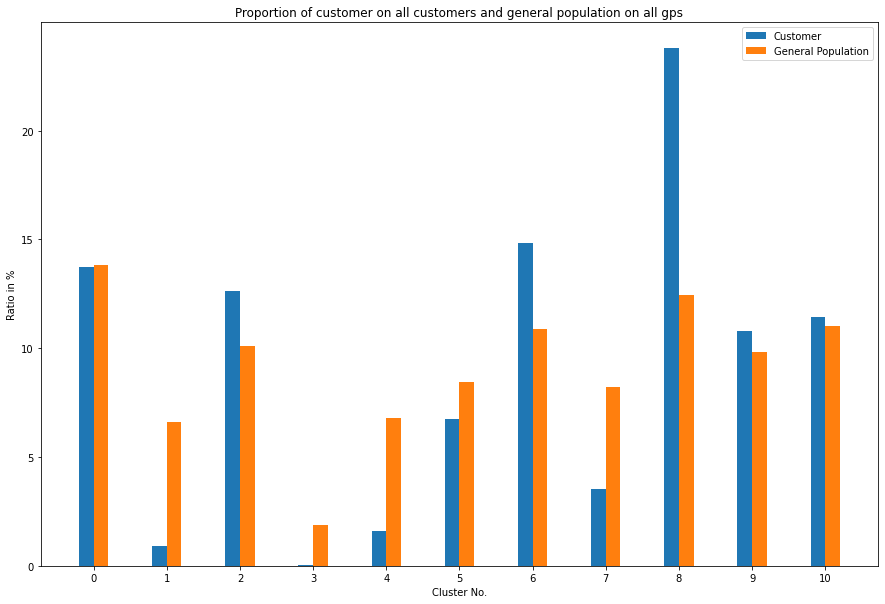

In [48]:
# plot Proportion of customer on all customers and general population on all gps

labels = df_gp_customers_value.index.tolist()
customer_values = (df_gp_customers_value['values of customers']/df_gp_customers_value['values of customers'].sum()*100).tolist()
gp_values = (df_gp_customers_value['values of gp']/df_gp_customers_value['values of gp'].sum()*100).tolist()

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x - width/2, customer_values, width, label='Customer')
rects2 = ax.bar(x + width/2, gp_values, width, label='General Population')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Ratio in %')
ax.set_xlabel('Cluster No.')

ax.set_title('Proportion of customer on all customers and general population on all gps')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

The difference between customers and general population is largest in clusters 8, and lowest in clusters 1.

In [62]:
azdias_pca_ = pca.fit(azdias_clean)
explained_variance_ratio = pd.DataFrame(azdias_pca_.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])

In [68]:
weights_azdias = pd.DataFrame(azdias_pca_.components_, columns = azdias_clean.columns.values)
final_result = pd.concat([explained_variance_ratio, weights_azdias], axis = 1)
final_result

,EXPLAINED_VARIANCE,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_O,OST_WEST_KZ_W
0,0.055246,-0.033882,0.086904,-0.056877,0.022502,0.101430,0.018952,-0.038179,-0.101980,-0.006994,...,0.035309,0.032640,0.030560,0.057640,0.053880,0.052873,0.027313,-0.002449,0.084582,-0.084582
1,0.046956,0.016259,-0.000553,-0.025024,-0.031942,0.018531,0.015894,-0.010552,-0.003834,0.005421,...,-0.022388,-0.011057,-0.017901,-0.015075,-0.002583,-0.010324,0.051642,0.000713,-0.039696,0.039696
2,0.040568,0.026821,-0.057217,0.040536,-0.011306,-0.042702,-0.032507,0.023381,0.066106,-0.010254,...,0.021374,0.019499,-0.001264,0.006550,-0.021860,-0.021027,0.001158,0.000305,0.131716,-0.131716
3,0.031782,-0.164566,0.051808,0.124523,0.211277,0.002930,-0.015704,0.104707,0.074093,-0.011198,...,-0.010386,-0.039980,0.024954,0.017953,0.022122,0.013927,-0.023688,0.000369,-0.053171,0.053171
4,0.025460,0.069443,-0.103693,0.086972,-0.011038,0.064741,0.036772,0.034827,0.107142,0.016522,...,0.022737,0.036666,0.002065,0.019205,0.014293,0.013700,0.018010,-0.001105,0.103053,-0.103053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.001586,0.131717,-0.005761,-0.268033,0.060825,0.085927,-0.031769,-0.076795,0.046042,-0.041970,...,-0.020113,0.004993,-0.008175,-0.036712,-0.008947,0.008479,0.006492,0.000388,0.022817,-0.022817
196,0.001564,-0.040676,-0.049242,0.076116,-0.023362,0.009874,-0.004921,0.030918,0.041577,-0.029233,...,-0.020666,-0.010025,-0.021323,-0.029231,0.010044,0.022013,-0.020529,0.000050,0.028823,-0.028823
197,0.001542,-0.086913,0.046104,0.070739,-0.049866,0.098746,-0.056029,0.064033,-0.019183,0.047423,...,0.028306,-0.003517,0.033562,0.024539,-0.016046,-0.031211,-0.020324,-0.000816,-0.007430,0.007430
198,0.001512,0.068446,-0.016054,-0.154381,-0.007705,0.291113,-0.148549,-0.088994,0.074319,-0.037385,...,0.026677,-0.004198,0.023862,0.030397,-0.013191,-0.023056,-0.016447,-0.000146,-0.014995,0.014995


In [76]:
#get the top positice and negative weights for first 3 components
for componentnr in range(1,4):
    weight_num=5
    print("Principal Component Number: ", (componentnr),'\n')    
    print("Top Positive weights:")
    print(final_result.iloc[(componentnr)-1].sort_values(ascending=False)[:weight_num],'\n')
    print("Top Negative weights:")
    print(final_result.iloc[(pc)-1].sort_values()[:weight_num], '\n')

Principal Component Number:  1 

Top Positive weights:
HH_EINKOMMEN_SCORE    0.176726
CAMEO_DEUG_2015       0.172319
FINANZ_HAUSBAUER      0.137887
ARBEIT                0.128880
EWDICHTE              0.114878
Name: 0, dtype: float64 

Top Negative weights:
KBA05_ANTG1       -0.168676
KBA13_ANTG1       -0.164451
MOBI_RASTER       -0.159418
KBA05_GBZ         -0.157813
KBA13_AUTOQUOTE   -0.144121
Name: 0, dtype: float64 

Principal Component Number:  2 

Top Positive weights:
KBA05_KRSOBER    0.224249
KBA05_ANHANG     0.206021
KBA05_MOTRAD     0.204938
KBA05_DIESEL     0.200453
KBA05_MAXSEG     0.198724
Name: 1, dtype: float64 

Top Negative weights:
KBA05_ANTG1       -0.168676
KBA13_ANTG1       -0.164451
MOBI_RASTER       -0.159418
KBA05_GBZ         -0.157813
KBA13_AUTOQUOTE   -0.144121
Name: 0, dtype: float64 

Principal Component Number:  3 

Top Positive weights:
KBA13_KMH_140_210       0.158657
KBA13_HALTER_20         0.139864
KBA13_KMH_180           0.134699
KBA13_ALTERHALTER_60   

In [78]:
#values for the first 3 principles for cluster 8 and 1
print(kmeans_model.cluster_centers_[8,:3])
print(kmeans_model.cluster_centers_[1,:3])

[ 1.60199935 -0.57034276 -0.83148514]
[-2.02673462  1.51693277 -5.87511448]


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [62]:
#mailout_train = pd.read_csv('../data_arvato_bertelsmann/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_pickle("../data_arvato_bertelsmann/mailout_train.pkl")


In [63]:
X_train = mailout_train.drop('RESPONSE', axis=1)
y_train = mailout_train['RESPONSE']
y_train.shape

(42962,)

In [64]:
X_train.shape

(42962, 366)

In [65]:
df_train  = clean_data(X_train, False)

df columns 18 and 19 converted to float
shape is:  (42962, 364)
df columns with more than 40 percent missing values dropped
dropped columns are:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'KK_KUNDENTYP'],
      dtype='object')
shape is:  (42962, 359)
df rows with 25 missing values dropped
shape is:  (42962, 359)
columns with correlation more than 0.7 are dropped
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (42962, 253)
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (42962, 253)
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (42962, 253)
Imputing nan values with mode
shape after imputing the values (42962, 300)
Shape after normalising (42962, 300)


In [66]:
#split into test and train data
X_train, X_test, y_train, y_test = train_test_split(df_train, y_train, test_size=0.3, random_state=42)

In [67]:
# Create pipeline for classifier
pipeline = Pipeline([('classifier', RandomForestClassifier())])

paramter = [{'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [10, 50, 100],
                 'classifier__max_features': [1, 2, 3]},
            {'classifier': [GradientBoostingRegressor(random_state=42)],
                 'classifier__n_estimators': [50, 100, 200],
                 'classifier__min_samples_split': [2, 3, 4]}]

#paramter = [{'classifier': [LogisticRegression(random_state=42))],
#                 'classifier__penalty': ['l2'],
#                 'classifier__C': np.logspace(0, 5)}, 


In [68]:
#grid search
cv_obj = GridSearchCV(estimator=pipeline, param_grid=paramter, scoring = 'roc_auc')

#modelfit
cv_fit = cv_obj.fit(X_train, y_train)

# get the best classifier
choosen_classfier = cv_fit.best_estimator_
clf_predictions = choosen_classfier.predict(X_test)

print("ROC score on test data:", roc_auc_score(y_test, clf_predictions))


ROC score on test data: 0.7609329939231682


In [74]:
choosen_classfier

Pipeline(steps=[('classifier',
                 GradientBoostingRegressor(min_samples_split=4, n_estimators=50,
                                           random_state=42))])

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [69]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_pickle("../data_arvato_bertelsmann/mailout_test.pkl")

In [70]:
#clean test data
mailout_test_clean = clean_data(mailout_test, False)

df columns 18 and 19 converted to float
shape is:  (42833, 364)
df columns with more than 40 percent missing values dropped
dropped columns are:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'KK_KUNDENTYP'],
      dtype='object')
shape is:  (42833, 359)
df rows with 25 missing values dropped
shape is:  (42833, 359)
columns with correlation more than 0.7 are dropped
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (42833, 253)
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (42833, 253)
this columns from customer df are dropped:  ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
shape is:  (42833, 253)
Imputing nan values with mode
shape after imputing the values (42833, 300)
Shape after normalising (42833, 300)


In [72]:
# prediction with choosen classifier
prediction = choosen_classfier.predict(mailout_test_clean)
submission = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=prediction)

In [76]:
submission.rename(columns={0: "RESPONSE"}, inplace=True)
submission.to_csv('Submission_kaggle.csv', index=True)

In [75]:
submission

,RESPONSE
LNR,
1754,0.028627
1770,0.019985
1465,0.004713
1470,0.005229
1478,0.000414
...,...
67615,0.012312
67938,0.006186
67942,0.018789
